# Unzipping and importing

In [1]:
!ls
!mkdir dataset
!unrar x "22.Cotton-wool spots.rar" "dataset/"

'22.Cotton-wool spots.rar'   sample_data

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from 22.Cotton-wool spots.rar

Creating    dataset/22.Cotton-wool spots                              OK
Extracting  dataset/22.Cotton-wool spots/1ffa9414-8d87-11e8-9daf-6045cb817f5b..JPG       0%  1%  2%  3%  4%  5%  6%  OK 
Extracting  dataset/22.Cotton-wool spots/1ffa9415-8d87-11e8-9daf-6045cb817f5b..JPG       6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19%  OK 
Extracting  dataset/22.Cotton-wool spots/1ffa9416-8d87-11e8-9daf-6045cb817f5b..JPG      20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30%  OK 
Extracting  dataset/22.Cotton-wool spots/1ffa9417-8d87-11e8-9daf-6045cb817f5b..JPG      31% 32% 33% 34% 35% 36%  OK 
Extracting  dataset/22.Cotton-wool spots/1ffa9419-8d87-11e8-9daf-6045cb817f5b..

In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
images_path = 'dataset/22.Cotton-wool spots'
image_files = os.listdir(images_path + '/')

In [4]:
image_files

['1ffa9419-8d87-11e8-9daf-6045cb817f5b..JPG',
 '1ffa941a-8d87-11e8-9daf-6045cb817f5b..JPG',
 '1ffa941c-8d87-11e8-9daf-6045cb817f5b..JPG',
 '1ffa941b-8d87-11e8-9daf-6045cb817f5b..JPG',
 '1ffa941d-8d87-11e8-9daf-6045cb817f5b..JPG',
 '1ffa941e-8d87-11e8-9daf-6045cb817f5b..JPG',
 '1ffa9415-8d87-11e8-9daf-6045cb817f5b..JPG',
 '1ffa9414-8d87-11e8-9daf-6045cb817f5b..JPG',
 '1ffa9416-8d87-11e8-9daf-6045cb817f5b..JPG',
 '1ffa9417-8d87-11e8-9daf-6045cb817f5b..JPG']

# 1st complete process

Reading the image using PIL library and reshaping the image

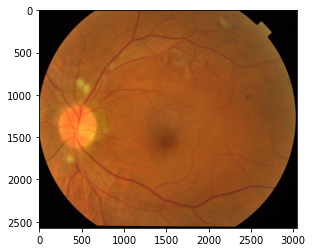

In [5]:
img = Image.open(os.path.join(images_path,image_files[2]))
img = img.resize((3046,2572))
plt.imshow(img)
plt.show()

Converting Image object to numpy array to extract layers (red & green) of the RGB image



*   Selecting the green layer because it gives a high contrast grayscale image of the fundus image
*   Selecting the red layer because in the red layer, the optic disc is clearly distinguishable



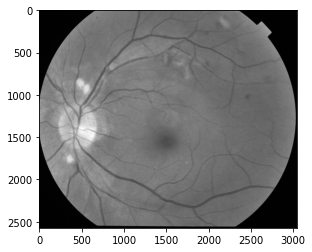

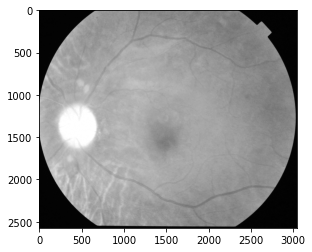

In [7]:
image1_array = np.array(img)
green = image1_array[:,:,1]
red = image1_array[:,:,0]
plt.imshow(green, cmap='gray')
plt.show()
plt.imshow(red, cmap='gray')
plt.show()

Thresholding the red layer of the fundus image to detect bright regions which may be cotton wool spots and optic disc

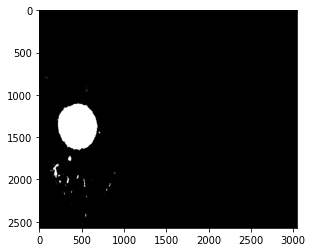

In [8]:
red_thresh = np.array(red > 205, dtype = np.uint8)
plt.imshow(red_thresh,cmap = 'gray')
plt.show()

Morphological Closing the thresholded image to fill the small gaps in the thresholded image or to improve the shape of the thresholded regions

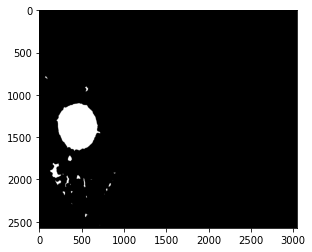

In [9]:
kernel = cv2.getStructuringElement(shape = cv2.MORPH_ELLIPSE, ksize = (41,41))
#kernel = np.ones((41,41),np.uint8)
red_thresh_closing = cv2.morphologyEx(red_thresh, cv2.MORPH_CLOSE, kernel)
plt.imshow(red_thresh_closing, cmap='gray')
plt.show()

Finding the contours present on the closed thresholded image of the red layer and selecting the contour with maximum area as the optic disc </br>
With this a rough estimation of the optic disc is obtained which can be used later to remove optic disc from the fundus image, because optic disc is usually confused to be a cotton wool spots because of the similarity in shape and colour

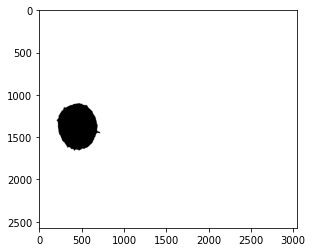

(2572, 3046)


In [10]:
red_contours, hier = cv2.findContours(red_thresh_closing,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
fruit = np.ones((2572,3046))
roi = max(red_contours, key = cv2.contourArea)
contours_img = cv2.drawContours(fruit, [roi], -1, (0,0,0), thickness=-1)
plt.imshow(contours_img, cmap='gray')
plt.show()
print(np.shape(contours_img))

With this one part of the process is completed, i.e., rough estimation of the optic disc

Now again enhancing the green layer of fundus image to obtain the cotton wool spots

First, the green layer of the image is median filtered to remove any salt and pepper noise

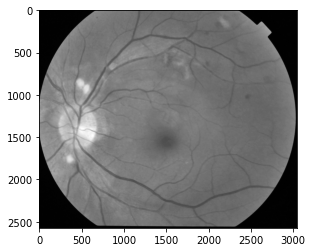

In [11]:
median = cv2.medianBlur(green, 11)
plt.imshow(median, cmap='gray')
plt.show()

Now, the median filtered image is closed to remove the blood vessels

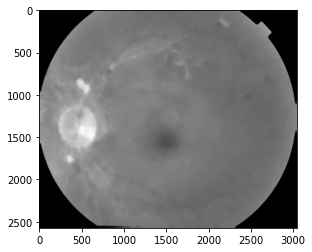

In [12]:
kernel = cv2.getStructuringElement(shape = cv2.MORPH_ELLIPSE, ksize = (51,51))
closing = cv2.morphologyEx(median, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')
plt.show()

Non-linear enhancement of the morphologically closed green layer to enhance the bright regions more. (Gamma correction is performed)

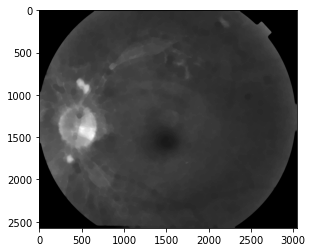

In [13]:
gamma = 2
gamma_corrected = np.array(np.max(closing)*(closing / np.max(closing)) ** gamma, dtype = 'uint8')
plt.imshow(gamma_corrected, cmap='gray')
plt.show()

After gamma correction, entropy function is applied to characterize the texture of the image.

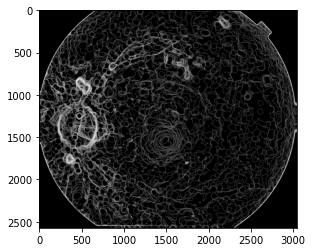

In [14]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
entropy = entropy(gamma_corrected, disk(5))
plt.imshow(entropy, cmap = 'gray')
plt.show()

*   Scaling the entropy of the image and thresholding to obtain a B&W image of possible bright lesions.
*   Median filtering the B&W image to remove any unnecessary dot like structures
*  Then closing the filtered image to fill the gaps



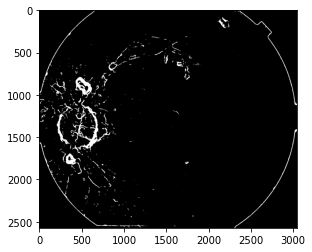

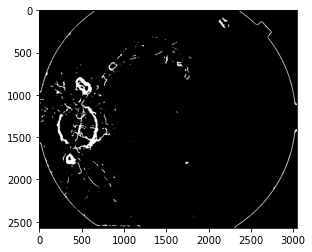

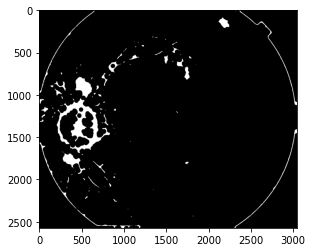

In [15]:
scaled_entr = (entropy - np.min(entropy)) / (np.max(entropy) - np.min(entropy))

bw = np.array(scaled_entr > 0.5, dtype = np.uint8)
plt.imshow(bw, cmap = 'gray')
plt.show()

bw = cv2.medianBlur(bw, 11)
plt.imshow(bw, cmap = 'gray')
plt.show()

kernel = cv2.getStructuringElement(shape = cv2.MORPH_ELLIPSE, ksize = (51,51))
#kernel = np.ones((41,41),np.uint8)
bw_closing = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
plt.imshow(bw_closing, cmap='gray')
plt.show()

Again an estimated optic disc is obtained by performing before mentioned contour analysis. </br>
Both the optic discs obtained may not be same because of the noise and the effects resulted due to closing the B&W image. </br>

Both the estimated optic discs obtained are removed from the closed B&W image to obtain the possible cotton wool spots.

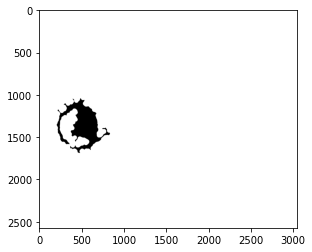

(2572, 3046)


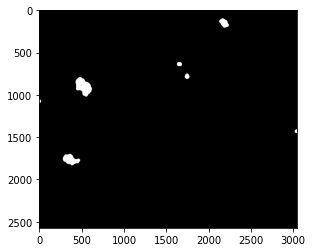

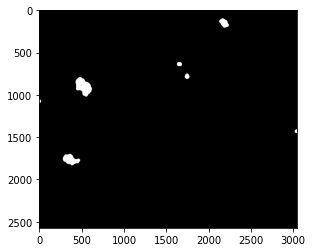

In [16]:
bw_contours, hier = cv2.findContours(bw_closing,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
fruit = np.ones((2572,3046))
roi = max(bw_contours, key = cv2.contourArea)
contours_img2 = cv2.drawContours(fruit, [roi], -1, (0,0,0), thickness=-1)
plt.imshow(contours_img2, cmap='gray')
plt.show()
print(np.shape(contours_img2))

final = bw_closing*contours_img2*contours_img
kernel = cv2.getStructuringElement(shape = cv2.MORPH_ELLIPSE, ksize = (41,41))
#kernel = np.ones((41,41),np.uint8)
final_opening = cv2.morphologyEx(final, cv2.MORPH_OPEN, kernel)
plt.imshow(final_opening, cmap='gray')
plt.show()

kernel = cv2.getStructuringElement(shape = cv2.MORPH_ELLIPSE, ksize = (51,51))
#kernel = np.ones((41,41),np.uint8)
cws_closing = cv2.morphologyEx(final_opening, cv2.MORPH_CLOSE, kernel)
plt.imshow(cws_closing, cmap='gray')
plt.show()

Plotting the cotton wool spots on the original image. </br>
Results may not be completely accurate. Some non-CWS spots may be detected as CWS also.

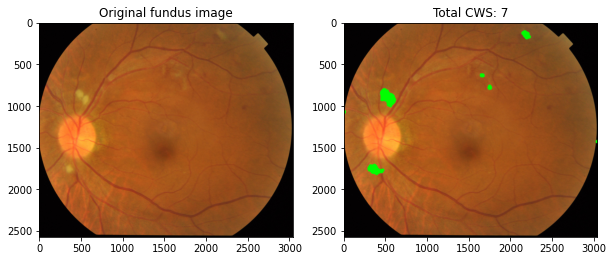

In [17]:
final_image = np.array(img)
cws_closing = np.array(cws_closing, dtype = np.uint8)
cws_contours, hier = cv2.findContours(cws_closing,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
final_cws = cv2.drawContours(final_image, cws_contours, -1, (0,255,0), thickness=-1)
fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].imshow(image1_array)
ax[0].set_title('Original fundus image')
ax[1].imshow(final_cws)
ax[1].set_title('Total CWS: {}'.format(len(cws_contours)))
plt.show()